# Reflector

This example shows how to use PyAEDT to create an HFSS SBR+ project from an
HFSS antenna and run a simulation.

Keywords: **HFSS**,  **SBR+**, **reflector**.

## Perform imports and define constants

Perform required imports and set up the local path to the path for the PyAEDT
directory.

In [1]:
import tempfile
import time

import ansys.aedt.core
from ansys.aedt.core.examples.downloads import download_sbr

Define constants.

In [2]:
AEDT_VERSION = "2024.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

## Create temporary directory

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [3]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys2")

## Download project

In [4]:
project_full_name = download_sbr(local_path=temp_folder.name)

## Define designs

Define two designs, one source and one target, with each design connected to
a different object.

In [5]:
target = ansys.aedt.core.Hfss(
    project=project_full_name,
    design="Cassegrain_",
    solution_type="SBR+",
    version=AEDT_VERSION,
    new_desktop=True,
    non_graphical=NG_MODE,
)

source = ansys.aedt.core.Hfss(
    project=target.project_name,
    design="feeder",
    version=AEDT_VERSION,
)

PyAEDT INFO: Parsing C:\Users\ITA\AppData\Local\Temp\tmphfjszu4i.ansys2\sbr\Cassegrain.aedt.
PyAEDT INFO: Python version 3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)].
PyAEDT INFO: PyAEDT version 0.16.1.
PyAEDT INFO: Initializing new Desktop session.
PyAEDT INFO: Log on console is enabled.
PyAEDT INFO: Log on file C:\Users\ITA\AppData\Local\Temp\pyaedt_ITA_02bdb525-d906-4158-b4dc-0da6cbb5ef43.log is enabled.
PyAEDT INFO: Log on AEDT is disabled.
PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.
PyAEDT INFO: File C:\Users\ITA\AppData\Local\Temp\tmphfjszu4i.ansys2\sbr\Cassegrain.aedt correctly loaded. Elapsed time: 0m 0sec
PyAEDT INFO: Launching PyAEDT with gRPC plugin.
PyAEDT INFO: New AEDT session is starting on gRPC port 64608.
PyAEDT INFO: Electronics Desktop started on gRPC port: 64608 after 15.958040475845337 seconds.
PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64
PyAEDT INFO: Ansoft.ElectronicsDesk

## Define linked antenna

Define a linked antenna. This is HFSS far field applied to HFSS SBR+.

In [6]:
target.create_sbr_linked_antenna(
    source, target_cs="feederPosition", field_type="farfield"
)

PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 1sec
PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec
PyAEDT INFO: Native component Linked Antenna feeder_CS65ZJ has been correctly created.


## Assign boundaries

Assign boundaries.

In [7]:
target.assign_perfecte_to_sheets(["Reflector", "Subreflector"])
target.mesh.assign_curvilinear_elements(["Reflector", "Subreflector"])

PyAEDT INFO: Parsing design objects. This operation can take time
PyAEDT INFO: Refreshing bodies from Object Info
PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec
PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec
PyAEDT INFO: Boundary Perfect E PerfE_VZO9NJ has been created.
PyAEDT INFO: Mesh class has been initialized! Elapsed time: 0m 0sec
PyAEDT INFO: Mesh class has been initialized! Elapsed time: 0m 0sec


## Create setup and solve

Create a setup and solve it.

In [8]:
setup1 = target.create_setup()
setup1.props["RadiationSetup"] = "ATK_3D"
setup1.props["ComputeFarFields"] = True
setup1.props["RayDensityPerWavelength"] = 2
setup1.props["MaxNumberOfBounces"] = 3
setup1["RangeType"] = "SinglePoints"
setup1["RangeStart"] = "10GHz"
target.analyze(cores=NUM_CORES)

PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.
PyAEDT INFO: Solving all design setups.
PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.
PyAEDT INFO: Design setup None solved correctly in 0.0h 0.0m 41.0s


True

## Postprocess

Plot results in AEDT.

In [9]:
variations = target.available_variations.nominal_w_values_dict
variations["Freq"] = ["10GHz"]
variations["Theta"] = ["All"]
variations["Phi"] = ["All"]
target.post.create_report(
    "db(GainTotal)",
    target.nominal_adaptive,
    variations=variations,
    primary_sweep_variable="Theta",
    context="ATK_3D",
    report_category="Far Fields",
)

PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec
PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec
PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


Plot results using Matplotlib.

PyAEDT INFO: Solution Data Correctly Loaded.


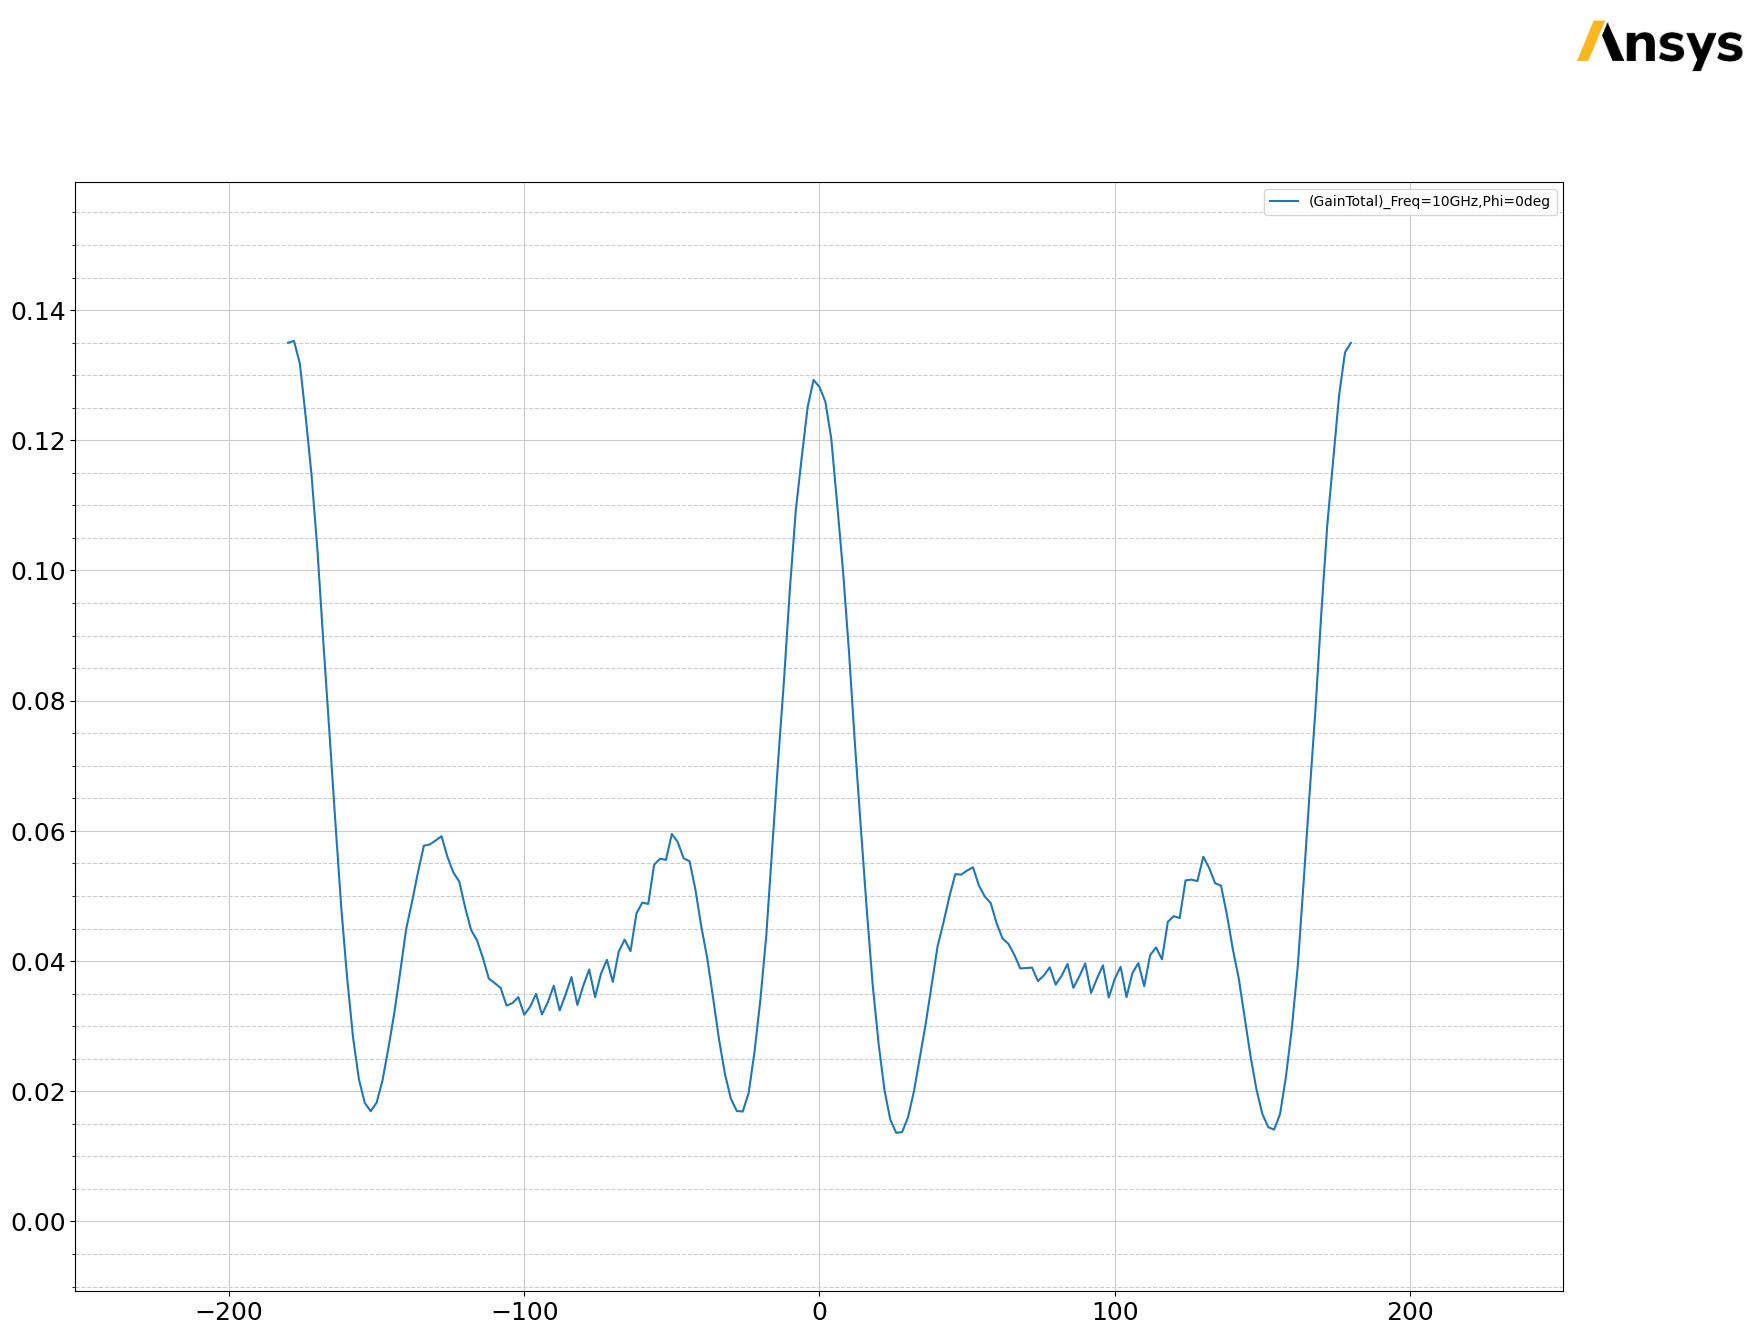

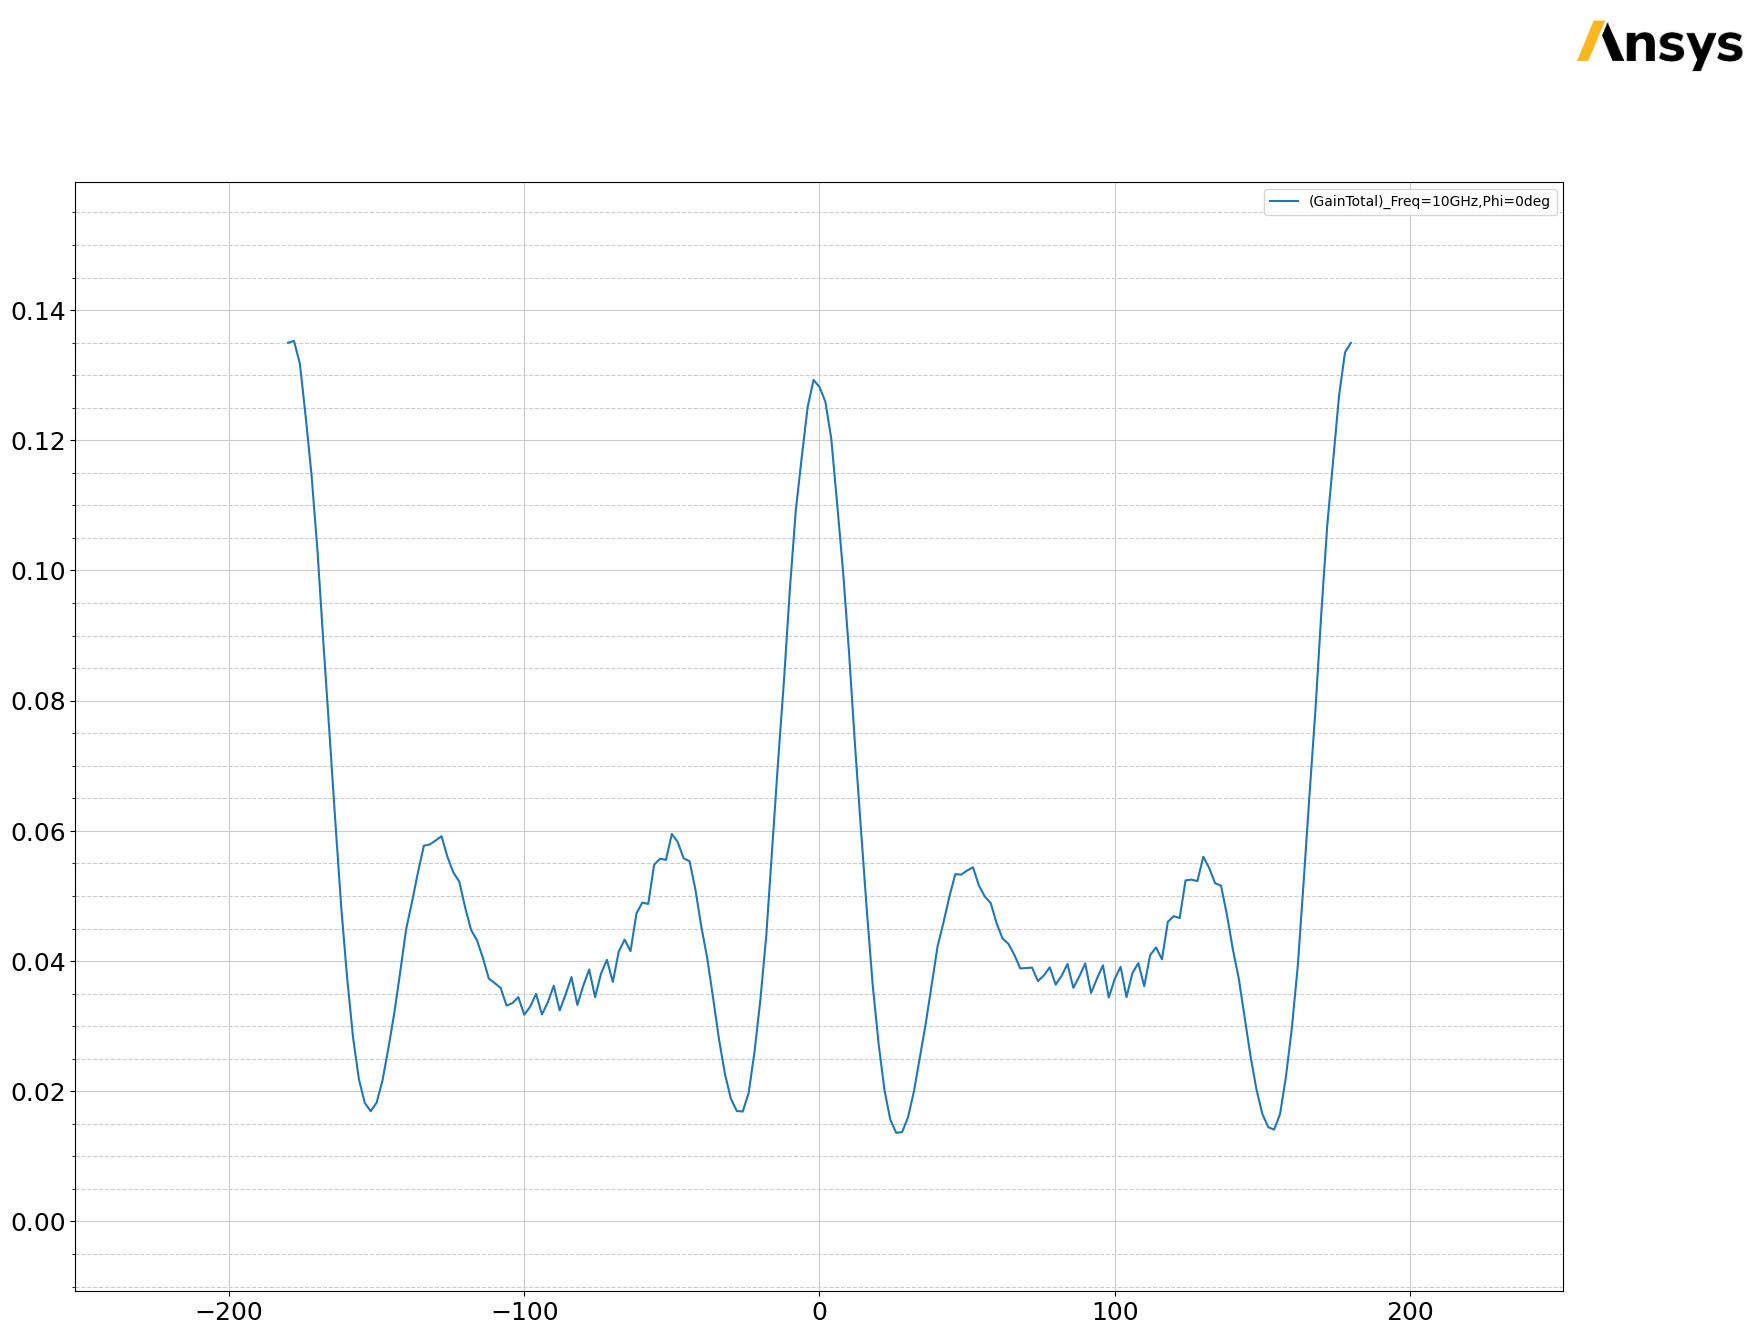

In [10]:
solution = target.post.get_solution_data(
    "GainTotal",
    target.nominal_adaptive,
    variations=variations,
    primary_sweep_variable="Theta",
    context="ATK_3D",
    report_category="Far Fields",
)
solution.plot()

## Release AEDT

Release AEDT and close the example.

In [11]:
target.save_project()
target.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project Cassegrain Saved correctly
PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``. If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell removes all temporary files, including the project folder.

In [12]:
temp_folder.cleanup()